In [1]:
from src.loaders.data_loader import load_train_data

df = load_train_data()
df


Day  Hour  Minute  DHI  DNI   WS     RH   T  TARGET
0         0     0       0    0    0  1.5  69.08 -12     0.0
1         0     0      30    0    0  1.5  69.06 -12     0.0
2         0     1       0    0    0  1.6  71.78 -12     0.0
3         0     1      30    0    0  1.6  71.75 -12     0.0
4         0     2       0    0    0  1.6  75.20 -12     0.0
...     ...   ...     ...  ...  ...  ...    ...  ..     ...
52555  1094    21      30    0    0  2.4  70.70  -4     0.0
52556  1094    22       0    0    0  2.4  66.79  -4     0.0
52557  1094    22      30    0    0  2.2  66.78  -4     0.0
52558  1094    23       0    0    0  2.1  67.72  -4     0.0
52559  1094    23      30    0    0  2.1  67.70  -4     0.0

[52560 rows x 9 columns]

In [2]:
from src.preprocessors.add_columns import add_sin_cos
from src.preprocessors.preprocessors import apply_standard_scale
from src.preprocessors.preprocessors import split_train_valid_test

df = add_sin_cos(df, "Hour")
train_df, valid_df, test_df = split_train_valid_test(df, [0.7, 0.2, 0.1])
scaled_train_df, scaled_valid_df, scaled_test_df = apply_standard_scale(train_df, valid_df, test_df)

print(scaled_train_df.shape, scaled_valid_df.shape, scaled_test_df.shape)

ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 11), (10511, 11), (5257, 11)
(36792, 11) (10511, 11) (5257, 11)



            Total window size: 96
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
            Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
            Label column name(s): None
        

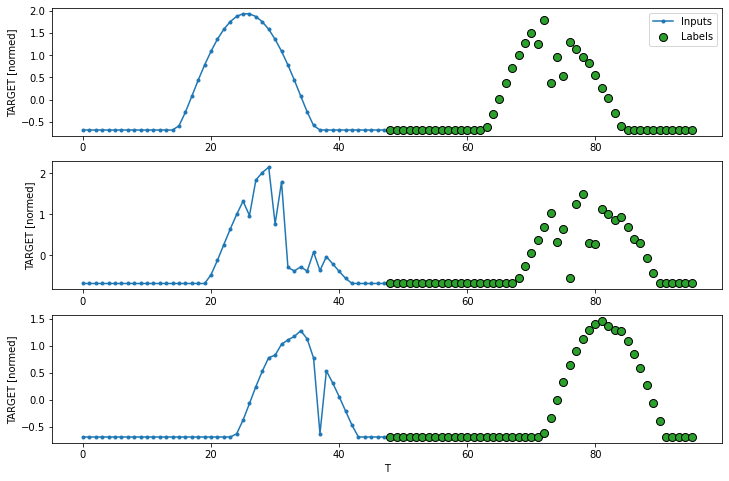

In [3]:
from src.loaders.window_generator import WindowGenerator
INPUT_STEPS = 48
OUT_STEPS = 48
TAU = 0.1
multi_window = WindowGenerator(
    scaled_train_df,
    scaled_valid_df,
    scaled_test_df,
    input_width=INPUT_STEPS,
    label_width=OUT_STEPS,
    shift=INPUT_STEPS,
)

multi_window.plot()
multi_window

In [4]:
column_index = [i for i, name in enumerate(df.columns) if name == "TARGET"][0]
column_index

multi_val_performance = {}
multi_performance = {}


326/326 [==============================] - 1s 2ms/step - loss: 0.4605 - mean_absolute_error: 0.9228 - mean_squared_error: 1.7098 - _pinball_loss: 0.4605


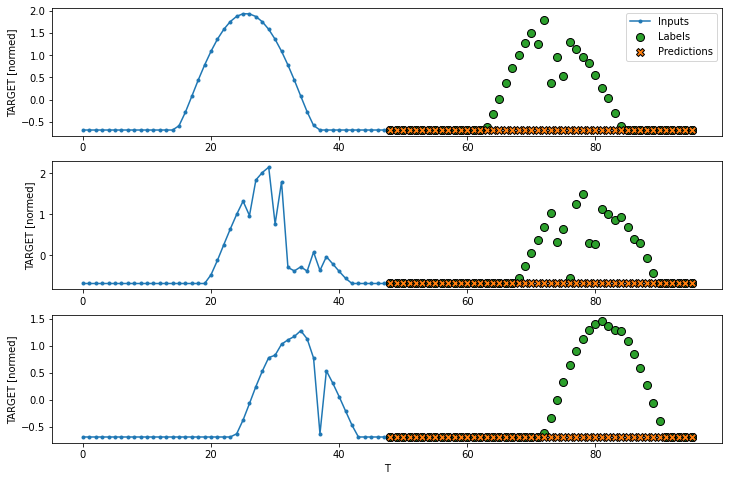

In [5]:
import tensorflow as tf
from src.model.multiple_output.baseline import MultiStepLastBaseline
from src.model.loss import pinball_loss
from src.trainers import compile_and_fit_with_pinball_loss

last_baseline = MultiStepLastBaseline(OUT_STEPS)

loss_function = pinball_loss(TAU)

last_baseline.compile(
    loss=loss_function,
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError(),
             tf.metrics.MeanSquaredError(),
             loss_function]
)

multi_val_performance["Last"] = last_baseline.evaluate(multi_window.valid)
multi_performance["Last"] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

326/326 [==============================] - 1s 2ms/step - loss: 0.1343 - mean_absolute_error: 0.2691 - mean_squared_error: 0.3865 - _pinball_loss: 0.1343


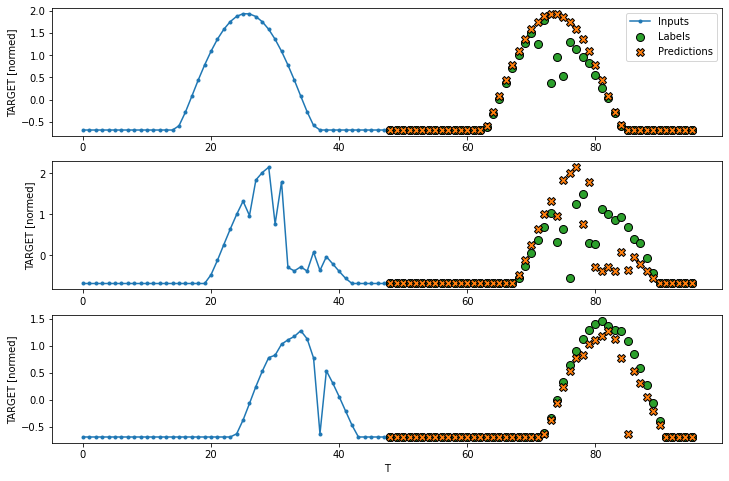

In [6]:
from src.model.multiple_output.repeat import RepeatBaseline

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=loss_function,
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError(),
             tf.metrics.MeanSquaredError(),
             loss_function]
)

multi_val_performance["Repeat"] = repeat_baseline.evaluate(multi_window.valid)
multi_performance["Repeat"] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Epoch 1/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.2226 - mean_absolute_error: 0.6223 - mean_squared_error: 0.6830 - _pinball_loss: 0.2226 - val_loss: 0.0728 - val_mean_absolute_error: 0.6430 - val_mean_squared_error: 0.9073 - val__pinball_loss: 0.0728
Epoch 2/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0600 - mean_absolute_error: 0.5120 - mean_squared_error: 0.6992 - _pinball_loss: 0.0600 - val_loss: 0.0541 - val_mean_absolute_error: 0.4917 - val_mean_squared_error: 0.8262 - val__pinball_loss: 0.0541
Epoch 3/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0492 - mean_absolute_error: 0.4321 - mean_squared_error: 0.6867 - _pinball_loss: 0.0492 - val_loss: 0.0525 - val_mean_absolute_error: 0.4788 - val_mean_squared_error: 0.8308 - val__pinball_loss: 0.0525
Epoch 4/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0486 - mean_absolute_error: 0.4282 - mean_squared_error: 0.6912 - _pinball

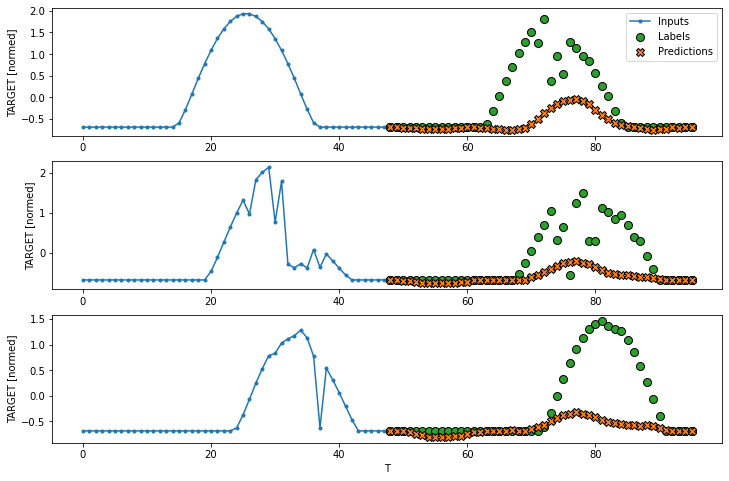

In [7]:
from src.model.multiple_output.linear import Linear

linear = Linear(OUT_STEPS, len(train_df.columns))
history = compile_and_fit_with_pinball_loss(linear, multi_window, TAU)
multi_val_performance["Linear"] = linear.evaluate(multi_window.valid)
multi_performance["Linear"] = linear.evaluate(multi_window.test, verbose=0)

multi_window.plot(linear)

Epoch 1/1000
1147/1147 [==============================] - 4s 4ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6895 - _pinball_loss: 0.0484 - val_loss: 0.0523 - val_mean_absolute_error: 0.4752 - val_mean_squared_error: 0.8270 - val__pinball_loss: 0.0523
Epoch 2/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6897 - _pinball_loss: 0.0484 - val_loss: 0.0523 - val_mean_absolute_error: 0.4749 - val_mean_squared_error: 0.8267 - val__pinball_loss: 0.0523
Epoch 3/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6897 - _pinball_loss: 0.0484 - val_loss: 0.0523 - val_mean_absolute_error: 0.4746 - val_mean_squared_error: 0.8264 - val__pinball_loss: 0.0523
Epoch 4/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6898 - _pinball

Epoch 30/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6894 - _pinball_loss: 0.0484 - val_loss: 0.0523 - val_mean_absolute_error: 0.4753 - val_mean_squared_error: 0.8269 - val__pinball_loss: 0.0523
Epoch 31/1000
1147/1147 [==============================] - 4s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.4262 - mean_squared_error: 0.6894 - _pinball_loss: 0.0484 - val_loss: 0.0523 - val_mean_absolute_error: 0.4749 - val_mean_squared_error: 0.8266 - val__pinball_loss: 0.0523
Epoch 32/1000
326/326 [==============================] - 1s 2ms/step - loss: 0.0523 - mean_absolute_error: 0.4749 - mean_squared_error: 0.8265 - _pinball_loss: 0.0523


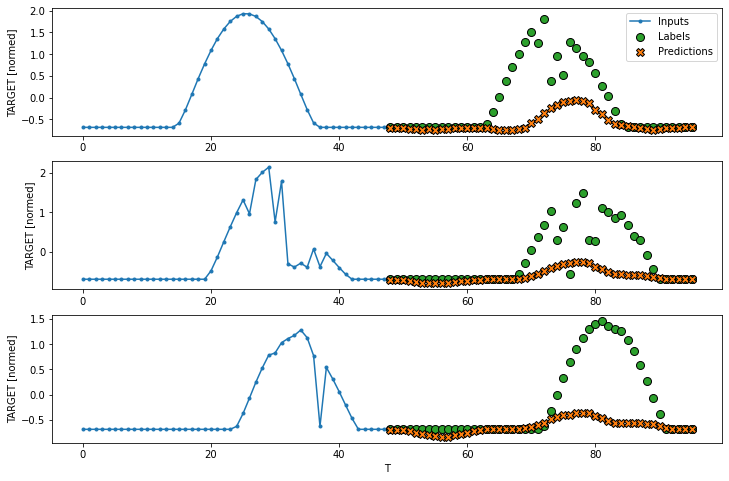

In [8]:
from src.model.multiple_output.dense import Dense

dense = Dense(OUT_STEPS, len(train_df.columns))
history = compile_and_fit_with_pinball_loss(linear, multi_window, TAU)
multi_val_performance["Dense"] = linear.evaluate(multi_window.valid)
multi_performance["Dense"] = linear.evaluate(multi_window.test, verbose=0)

multi_window.plot(linear)



Epoch 1/1000
1147/1147 [==============================] - 7s 5ms/step - loss: 0.0689 - mean_absolute_error: 0.5102 - mean_squared_error: 0.7506 - _pinball_loss: 0.0689 - val_loss: 0.0535 - val_mean_absolute_error: 0.4653 - val_mean_squared_error: 0.6825 - val__pinball_loss: 0.0535
Epoch 2/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0445 - mean_absolute_error: 0.3768 - mean_squared_error: 0.5095 - _pinball_loss: 0.0445 - val_loss: 0.0508 - val_mean_absolute_error: 0.4356 - val_mean_squared_error: 0.6359 - val__pinball_loss: 0.0508
Epoch 3/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0428 - mean_absolute_error: 0.3627 - mean_squared_error: 0.4905 - _pinball_loss: 0.0428 - val_loss: 0.0495 - val_mean_absolute_error: 0.4264 - val_mean_squared_error: 0.6166 - val__pinball_loss: 0.0495
Epoch 4/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0417 - mean_absolute_error: 0.3528 - mean_squared_error: 0.4796 - _pinball

Epoch 30/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0373 - mean_absolute_error: 0.3169 - mean_squared_error: 0.4402 - _pinball_loss: 0.0373 - val_loss: 0.0460 - val_mean_absolute_error: 0.3549 - val_mean_squared_error: 0.5205 - val__pinball_loss: 0.0460
Epoch 31/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0373 - mean_absolute_error: 0.3166 - mean_squared_error: 0.4390 - _pinball_loss: 0.0373 - val_loss: 0.0470 - val_mean_absolute_error: 0.3484 - val_mean_squared_error: 0.5189 - val__pinball_loss: 0.0470
Epoch 32/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0373 - mean_absolute_error: 0.3165 - mean_squared_error: 0.4391 - _pinball_loss: 0.0373 - val_loss: 0.0458 - val_mean_absolute_error: 0.3547 - val_mean_squared_error: 0.5257 - val__pinball_loss: 0.0458
Epoch 33/1000
1147/1147 [==============================] - 5s 4ms/step - loss: 0.0372 - mean_absolute_error: 0.3159 - mean_squared_error: 0.4378 - _pin

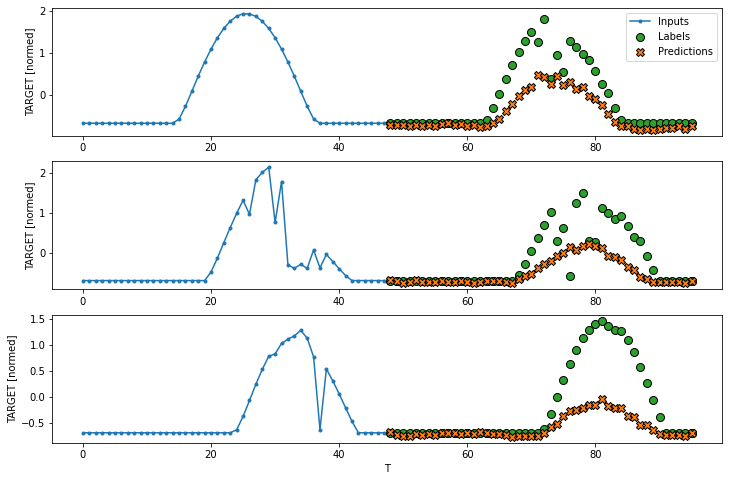

In [9]:
import src.model.multiple_output.convolution
import importlib
importlib.reload(src.model.multiple_output.convolution)
from src.model.multiple_output.convolution import Convolution


conv = Convolution(OUT_STEPS, OUT_STEPS, len(train_df.columns))
history = compile_and_fit_with_pinball_loss(conv, multi_window, TAU)
multi_val_performance["Conv"] = conv.evaluate(multi_window.valid)
multi_performance["Conv"] = conv.evaluate(multi_window.test, verbose=0)
multi_window.plot(conv)

Epoch 1/1000
1147/1147 [==============================] - 8s 6ms/step - loss: 0.1363 - mean_absolute_error: 0.7427 - mean_squared_error: 1.1521 - _pinball_loss: 0.1363 - val_loss: 0.0715 - val_mean_absolute_error: 0.6514 - val_mean_squared_error: 1.0581 - val__pinball_loss: 0.0715
Epoch 2/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0546 - mean_absolute_error: 0.4860 - mean_squared_error: 0.7634 - _pinball_loss: 0.0546 - val_loss: 0.0583 - val_mean_absolute_error: 0.5289 - val_mean_squared_error: 0.8215 - val__pinball_loss: 0.0583
Epoch 3/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0448 - mean_absolute_error: 0.3908 - mean_squared_error: 0.6003 - _pinball_loss: 0.0448 - val_loss: 0.0558 - val_mean_absolute_error: 0.5056 - val_mean_squared_error: 0.7847 - val__pinball_loss: 0.0558
Epoch 4/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0435 - mean_absolute_error: 0.3784 - mean_squared_error: 0.5822 - _pinball

Epoch 30/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0383 - mean_absolute_error: 0.3325 - mean_squared_error: 0.5084 - _pinball_loss: 0.0383 - val_loss: 0.0475 - val_mean_absolute_error: 0.4144 - val_mean_squared_error: 0.6647 - val__pinball_loss: 0.0475
Epoch 31/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0383 - mean_absolute_error: 0.3324 - mean_squared_error: 0.5082 - _pinball_loss: 0.0383 - val_loss: 0.0474 - val_mean_absolute_error: 0.4102 - val_mean_squared_error: 0.6595 - val__pinball_loss: 0.0474
Epoch 32/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0382 - mean_absolute_error: 0.3316 - mean_squared_error: 0.5068 - _pinball_loss: 0.0382 - val_loss: 0.0469 - val_mean_absolute_error: 0.4107 - val_mean_squared_error: 0.6625 - val__pinball_loss: 0.0469
Epoch 33/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.3313 - mean_squared_error: 0.5062 - _pin

Epoch 59/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0371 - mean_absolute_error: 0.3226 - mean_squared_error: 0.4908 - _pinball_loss: 0.0371 - val_loss: 0.0463 - val_mean_absolute_error: 0.3854 - val_mean_squared_error: 0.6277 - val__pinball_loss: 0.0463
Epoch 60/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0371 - mean_absolute_error: 0.3222 - mean_squared_error: 0.4902 - _pinball_loss: 0.0371 - val_loss: 0.0460 - val_mean_absolute_error: 0.3844 - val_mean_squared_error: 0.6256 - val__pinball_loss: 0.0460
Epoch 61/1000
1147/1147 [==============================] - 7s 6ms/step - loss: 0.0371 - mean_absolute_error: 0.3220 - mean_squared_error: 0.4899 - _pinball_loss: 0.0371 - val_loss: 0.0459 - val_mean_absolute_error: 0.3841 - val_mean_squared_error: 0.6263 - val__pinball_loss: 0.0459
Epoch 62/1000
326/326 [==============================] - 1s 3ms/step - loss: 0.0460 - mean_absolute_error: 0.3867 - mean_squared_error: 0.6310 - _pinba

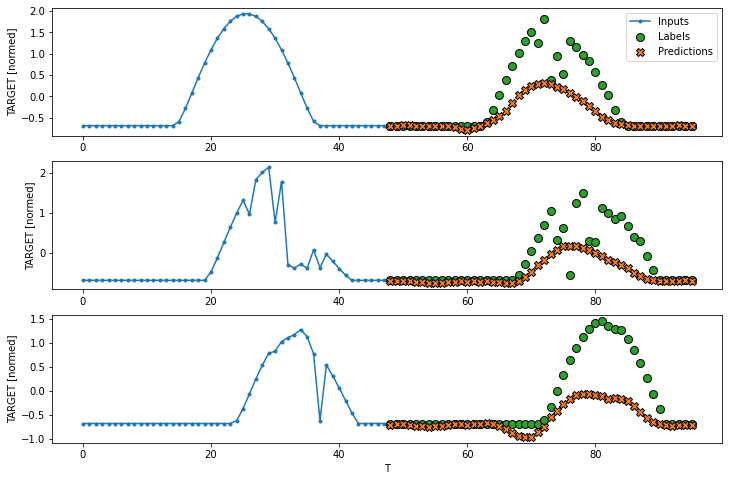

In [10]:
import src.model.multiple_output.rnn
importlib.reload(src.model.multiple_output.rnn)
from src.model.multiple_output.rnn import Lstm


lstm = Lstm(OUT_STEPS, len(df.columns))
history = compile_and_fit_with_pinball_loss(lstm, multi_window, TAU)
multi_val_performance["LSTM"] = lstm.evaluate(multi_window.valid)
multi_performance["LSTM"] = lstm.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm)

Epoch 1/1000
1147/1147 [==============================] - 186s 158ms/step - loss: 0.1468 - mean_absolute_error: 0.9666 - mean_squared_error: 1.7814 - _pinball_loss: 0.1468 - val_loss: 0.0759 - val_mean_absolute_error: 0.6603 - val_mean_squared_error: 1.0761 - val__pinball_loss: 0.0759
Epoch 2/1000
1147/1147 [==============================] - 182s 158ms/step - loss: 0.0577 - mean_absolute_error: 0.5103 - mean_squared_error: 0.8088 - _pinball_loss: 0.0577 - val_loss: 0.0708 - val_mean_absolute_error: 0.6220 - val_mean_squared_error: 1.0088 - val__pinball_loss: 0.0708
Epoch 3/1000
1147/1147 [==============================] - 182s 159ms/step - loss: 0.0544 - mean_absolute_error: 0.4829 - mean_squared_error: 0.7709 - _pinball_loss: 0.0544 - val_loss: 0.0678 - val_mean_absolute_error: 0.6044 - val_mean_squared_error: 0.9712 - val__pinball_loss: 0.0678
Epoch 4/1000
1147/1147 [==============================] - 182s 158ms/step - loss: 0.0523 - mean_absolute_error: 0.4637 - mean_squared_error: 0

1147/1147 [==============================] - 181s 158ms/step - loss: 0.0463 - mean_absolute_error: 0.4089 - mean_squared_error: 0.6329 - _pinball_loss: 0.0463 - val_loss: 0.0580 - val_mean_absolute_error: 0.4930 - val_mean_squared_error: 0.7602 - val__pinball_loss: 0.0580
Epoch 30/1000
1147/1147 [==============================] - 182s 159ms/step - loss: 0.0462 - mean_absolute_error: 0.4082 - mean_squared_error: 0.6308 - _pinball_loss: 0.0462 - val_loss: 0.0581 - val_mean_absolute_error: 0.4964 - val_mean_squared_error: 0.7683 - val__pinball_loss: 0.0581
Epoch 31/1000
1147/1147 [==============================] - 181s 158ms/step - loss: 0.0460 - mean_absolute_error: 0.4068 - mean_squared_error: 0.6285 - _pinball_loss: 0.0460 - val_loss: 0.0585 - val_mean_absolute_error: 0.4844 - val_mean_squared_error: 0.7461 - val__pinball_loss: 0.0585
Epoch 32/1000
1147/1147 [==============================] - 181s 158ms/step - loss: 0.0461 - mean_absolute_error: 0.4064 - mean_squared_error: 0.6267 - _p

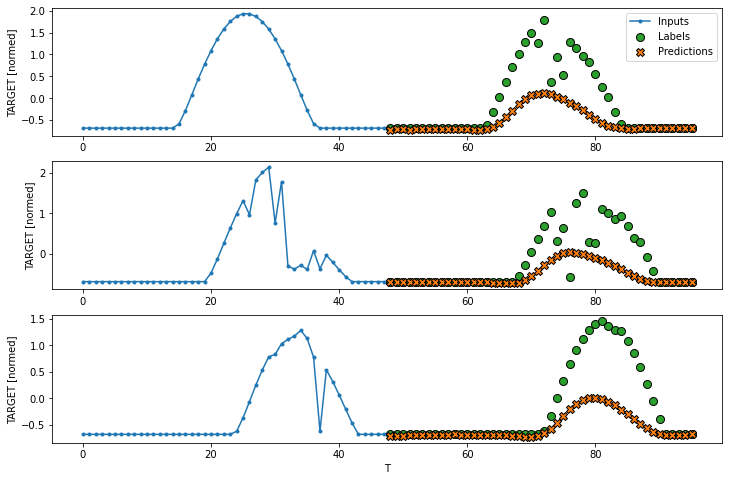

In [11]:
import src.model.multiple_output.feedback
importlib.reload(src.model.multiple_output.feedback)
from src.model.multiple_output.feedback import Feedback


feedback = Feedback(OUT_STEPS, len(df.columns), 32)

history = compile_and_fit_with_pinball_loss(feedback, multi_window, TAU)

multi_val_performance["AR LSTM"] = feedback.evaluate(multi_window.valid)
multi_performance["AR LSTM"] = feedback.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback)

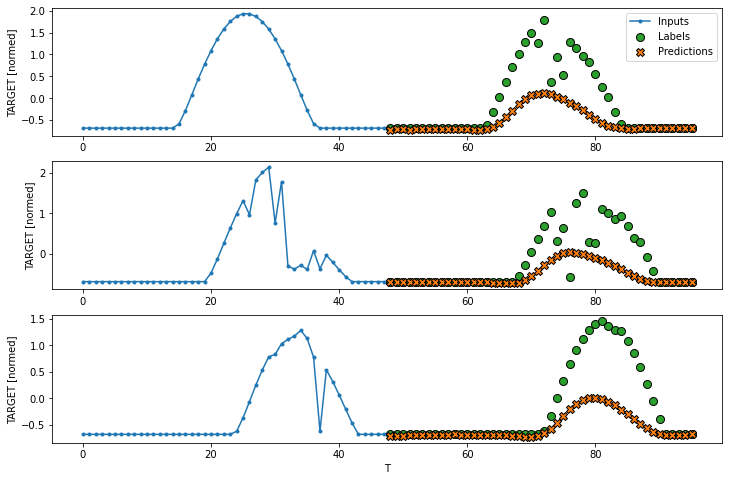

In [12]:
multi_window.plot(feedback)

In [29]:
y_pred = feedback.predict(multi_window.test_for_predict)

In [30]:
y_pred.shape

(5162, 48, 11)

In [ ]:
y_pred[0]

In [20]:
y_pred = y_pred[:, :, 8:9].reshape(-1)

In [23]:
from src.loaders.data_loader import load_test_data

test_df = load_test_data()

In [26]:
test_df["TARGET"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
331    0.0
332    0.0
333    0.0
334    0.0
335    0.0
Name: TARGET, Length: 27216, dtype: float64

In [34]:
import tensorflow as tf

ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=test_df,
            targets=None,
            sequence_length=96,
            sequence_stride=1,
            shuffle=False,
            batch_size=32,
)
test_df_x = []
test_df_y = []

for x, y in ds.map(lambda x: (x[:, :48, :], x[:, 48:, :])):
    test_df_x.append(x)
    test_df_y.append(y)

In [36]:
test_df_y

[<tf.Tensor: shape=(32, 48, 9), dtype=float64, numpy=
 array([[[ 1.        ,  0.        ,  0.        , ..., 26.93      ,
           3.6       ,  0.        ],
         [ 1.        ,  0.        , 30.        , ..., 27.12      ,
           3.5       ,  0.        ],
         [ 1.        ,  1.        ,  0.        , ..., 28.        ,
           3.4       ,  0.        ],
         ...,
         [ 1.        , 22.        , 30.        , ..., 42.06      ,
           3.2       ,  0.        ],
         [ 1.        , 23.        ,  0.        , ..., 41.42      ,
           3.1       ,  0.        ],
         [ 1.        , 23.        , 30.        , ..., 41.42      ,
           3.1       ,  0.        ]],
 
        [[ 1.        ,  0.        , 30.        , ..., 27.12      ,
           3.5       ,  0.        ],
         [ 1.        ,  1.        ,  0.        , ..., 28.        ,
           3.4       ,  0.        ],
         [ 1.        ,  1.        , 30.        , ..., 28.4       ,
           3.2       ,  0.    